In [1]:
import numpy as np

from tqdm import tqdm
from PTF import sample_curve
from torch.utils.data import DataLoader
from dataset import DriveLineEndDataset
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from scipy.ndimage import generic_filter
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, remove_small_objects, skeletonize, medial_axis, thin

In [2]:
drive_le_path = '/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/line_ends/DRIVE'
_dataset = DriveLineEndDataset(drive_le_path, threshold=0.008, min_size=15, train=True, augment=False)

Loading Data:   0%|                                      | 0/20 [00:00<?, ?it/s]


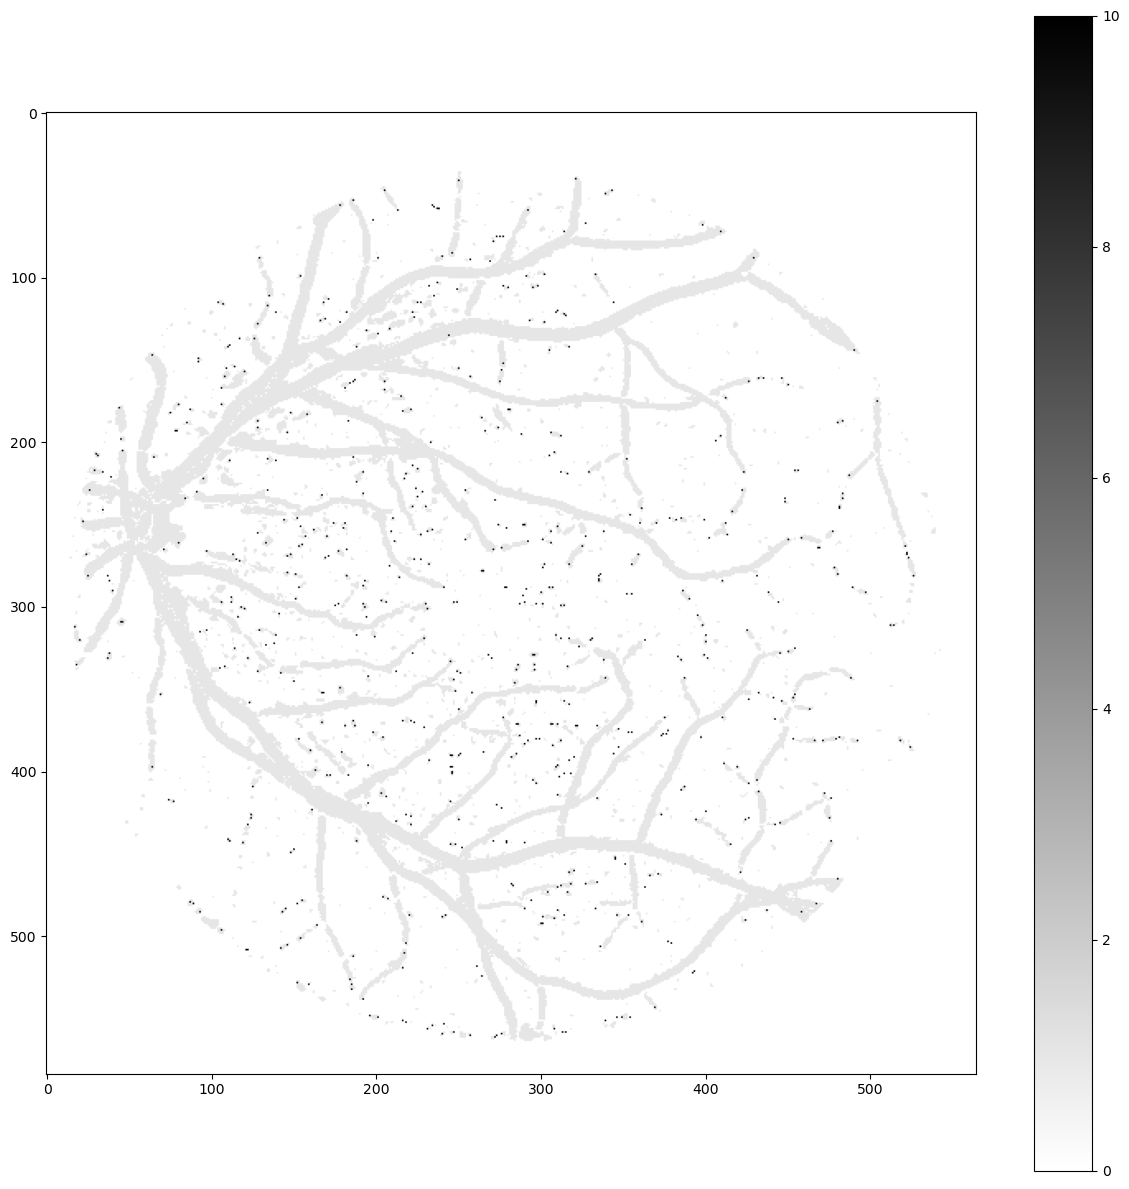

In [3]:
figure  = plt.figure(figsize=(15, 15))
end_locs = _dataset.subjects[0]['end_locs']

flux = (_dataset.subjects[0]['flux'][0] > 0.012).astype(int)
flux[end_locs[:, 0], end_locs[:, 1]] = 10.0
plt.imshow(flux, 'gray_r')
plt.colorbar()

In [4]:
def paste_patch(flux, patch, end_loc):
    assert patch.shape[0] == patch.shape[1]
    patch_size = patch.shape[0] // 2
    pad_size = (patch_size, patch_size)
    pad_width = ((0, 0), pad_size, pad_size, pad_size) if flux.ndim == 4 else ((0, 0), pad_size, pad_size)
    padded_flux = np.pad(flux, pad_width)
    start_x, start_y = end_loc[:2]
    end_x, end_y = end_loc[:2] + 2 * patch_size + 1
    if patch.ndim == 3:
        start_z = end_loc[2]
        end_z = end_loc[2] + 2 * patch_size + 1
        padded_flux[0, start_x:end_x, start_y:end_y, start_z:end_z] = patch
        new_flux = padded_flux[:, patch_size:-patch_size, patch_size:-patch_size, patch_size:-patch_size]
    else:
        padded_flux[0, start_x:end_x, start_y:end_y] = patch
        new_flux = padded_flux[:, patch_size:-patch_size, patch_size:-patch_size]
    assert new_flux.shape == flux.shape
    return new_flux

In [5]:
_params = {
        'sample_num': 16,
        'prob_num': 100,
        'cs_pt_num': 3,
        'step_len': 1.0
    }

data_loader = DataLoader(_dataset, batch_size=512, shuffle=False, num_workers=0)
image_fluxes = [s['flux'].copy() for s in _dataset.subjects]
subject_names = [s['subject_name'] for s in _dataset.subjects]

# loop over the dataset to post-process all the images
for batch in tqdm(data_loader, ncols=80, ascii=True, desc='Post-process: '):
    flux = batch['flux']    # .to(args.device)
    rads = batch['rads']    # .to(args.device)
    optimal_res = sample_curve(flux, rads, dir_num=32, **_params)
    for i in range(flux.shape[0]):
        curr_flux = flux[i][0].detach().cpu().numpy()                               # [H, W], [H, W, D]
        curr_loc = batch['end_loc'][i][0].int().detach().cpu().numpy()                    # [2,], [3,]
        curr_idx = batch['image_id'][i].detach().cpu().numpy()
        curr_path = optimal_res['path'][i].round().int().detach().cpu().numpy()             # [2, prob_num, 2/3]
        # filter the invalid positions
        patch_size = curr_flux.shape[0]
        curr_path = np.maximum(curr_path, 0)
        curr_path = np.minimum(curr_path, patch_size-1)
        if curr_flux.ndim == 3:
            curr_flux[curr_path[0, :, 0], curr_path[0, :, 1], curr_path[0, :, 2]] = 1.0
            curr_flux[curr_path[1, :, 0], curr_path[1, :, 1], curr_path[1, :, 2]] = 1.0
        else:
            curr_flux[curr_path[0, :, 0], curr_path[0, :, 1]] = 1.0
            curr_flux[curr_path[1, :, 0], curr_path[1, :, 1]] = 1.0
        # update the flux image in the dataset
        image_fluxes[curr_idx] = paste_patch(image_fluxes[curr_idx], curr_flux, curr_loc)

Post-process:   0%|                                       | 0/2 [00:00<?, ?it/s]

torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])
torch.Size([512, 32, 100, 2])


Post-process:  50%|###############5               | 1/2 [00:36<00:36, 36.43s/it]

torch.Size([512, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])
torch.Size([116, 32, 100, 2])


Post-process: 100%|###############################| 2/2 [00:50<00:00, 25.20s/it]

torch.Size([116, 32, 100, 2])


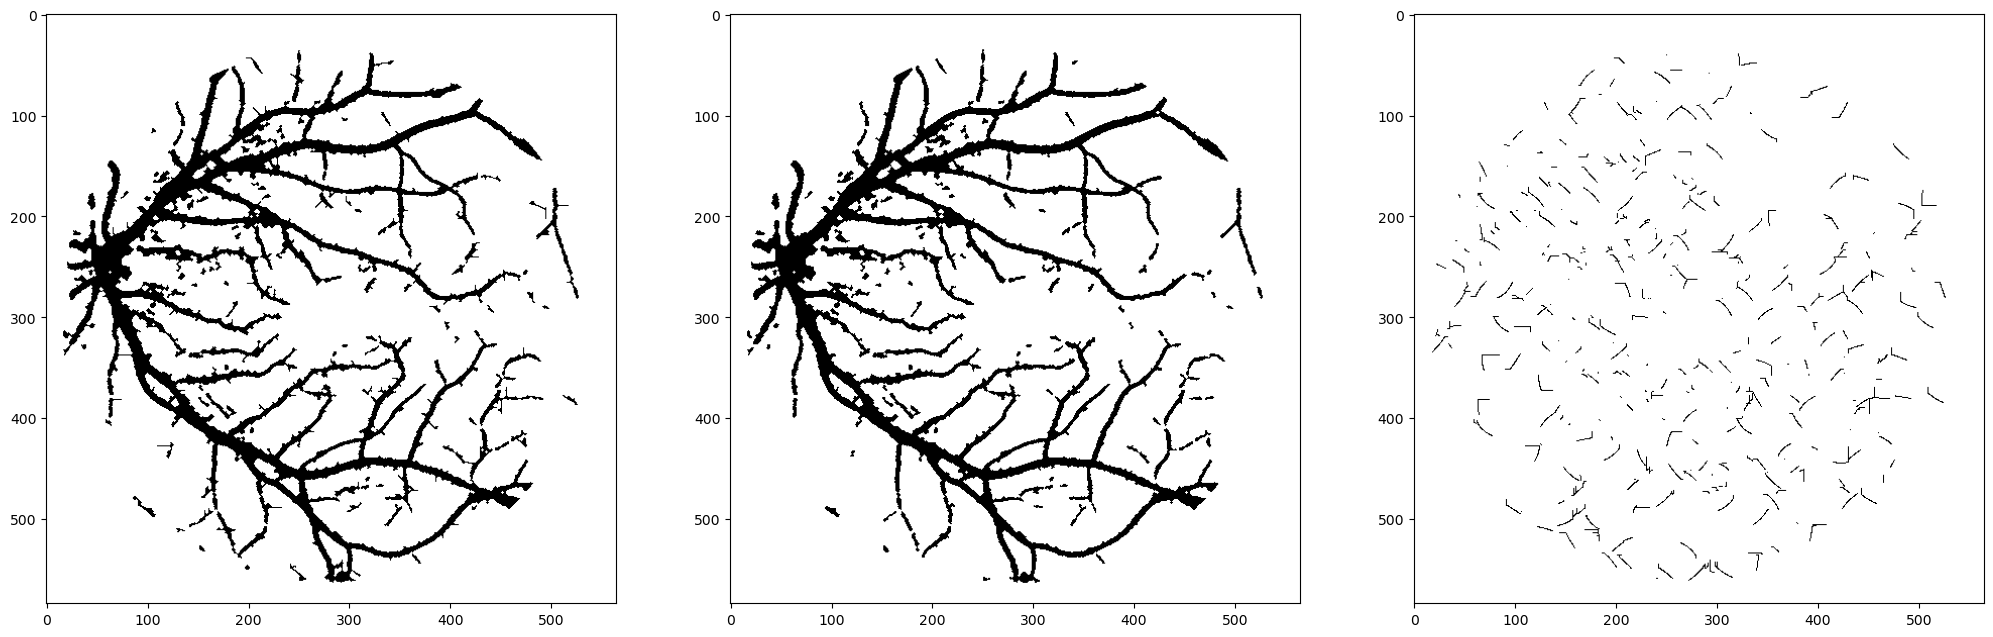

In [7]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 25))
# added_edges = gaussian(image_fluxes[0][0] > 0.5, sigma=0.4)
added_edges = image_fluxes[0][0] > 0.5
ax3.imshow(added_edges, cmap='gray_r')

fixed_fluxes = image_fluxes[0][0] + added_edges

bin_res = binary_closing(fixed_fluxes > 0.012)
bin_res = remove_small_objects(bin_res, min_size=15)
# bin_res = binary_erosion(bin_res)
ax1.imshow(bin_res, cmap='gray_r')

bin_flux = binary_closing(_dataset.subjects[0]['flux'][0] > 0.012)
bin_flux = remove_small_objects(bin_flux, min_size=15)
ax2.imshow(bin_flux, cmap='gray_r')

In [24]:
import SimpleITK as sitk
from skimage.morphology import skeletonize_3d, binary_closing, binary_erosion, remove_small_objects

In [53]:
file = '/Users/zhiweideng/Desktop/NICR/VesselAnalysis/EyeVessel/DRIVE/line_ends/flux_h1_subj_12.nii.gz'
image = sitk.ReadImage(file)

In [54]:
bin_path = '/Users/zhiweideng/Desktop/bin_res.nii.gz'
bin_res = sitk.GetArrayFromImage(image) > 0.06
bin_res = binary_closing(bin_res)
bin_res = binary_erosion(remove_small_objects(bin_res, min_size=30))
# bin_res = (skeletonize_3d(bin_res) > 0.5).astype(float)

flux_image = sitk.GetImageFromArray(bin_res.astype(float))
flux_image.CopyInformation(image)
sitk.WriteImage(flux_image, bin_path)

In [47]:
def detect_ends(window):
    if len(window) == 27:
        return window[13] == 1 and np.sum(window) == 2
    else:
        return window[4] == 1 and np.sum(window) == 2
    
detect_size = (3, 3, 3) if bin_res.ndim == 3 else (3, 3)
line_ends = generic_filter(bin_res, detect_ends, detect_size)
end_path = '/Users/zhiweideng/Desktop/line_ends.nii.gz'
flux_image = sitk.GetImageFromArray(line_ends)
flux_image.CopyInformation(image)
sitk.WriteImage(flux_image, end_path)

TypeError: dtype: bool is not supported.